**Question 1**

In [ ]:
import torch
import torch.nn as nn

# BasicBlock definition
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer
        self.downsample = downsample

    def forward(self, x):
        identity = x

        # First layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply downsampling
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the identity
        out += identity
        out = self.relu(out)

        return out

# ResNet-20 implementation
class ResNet20(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=16,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

         # Manually define each residual block

        ## Layer 1
        # Block 1
        self.layer1_block1 = BasicBlock(16, 16)
        # Block 2
        self.layer1_block2 = BasicBlock(16, 16)
        # Block 3
        self.layer1_block3 = BasicBlock(16, 16)

        ## Layer 2
        # Downsample from 16 to 32 filters
        self.layer2_downsample = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=1, stride=2,padding=0, bias=False),
            nn.BatchNorm2d(32)
        )
        # Block 1
        self.layer2_block1 = BasicBlock(16, 32, stride=2, downsample=self.layer2_downsample)
        # Block 2
        self.layer2_block2 = BasicBlock(32, 32)
         # Block 3
        self.layer2_block3 = BasicBlock(32, 32)

        ## Layer 3
        # Downsample from 32 to 64 filters
        self.layer3_downsample = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1, stride=2,padding=0, bias=False),
            nn.BatchNorm2d(64)
        )
        # Block 1
        self.layer3_block1 = BasicBlock(32, 64, stride=2, downsample=self.layer3_downsample)
        # Block 2
        self.layer3_block2 = BasicBlock(64, 64)
        # Block 3
        self.layer3_block3 = BasicBlock(64, 64)


        # Adaptive average pooling
        self.avgpool_ee_511 = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(64 * BasicBlock.expansion, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize weights using Kaiming He initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight
                )
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)



    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

         # Layer 1
        x = self.layer1_block1(x)
        x = self.layer1_block2(x)
        x = self.layer1_block3(x)

        # Layer 2
        x = self.layer2_block1(x)
        x = self.layer2_block2(x)
        x = self.layer2_block3(x)

        # Layer 3
        x = self.layer3_block1(x)
        x = self.layer3_block2(x)
        x = self.layer3_block3(x)


        # Average pooling
        x = self.avgpool_ee_511(x)

        # Flatten the tensor
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc(x)

        return x



In [ ]:
# Instantiate the ResNet20 model
model = ResNet20(num_classes=10)

# Create a random input tensor with batch size 9 and image size 32x32 (CIFAR-10)
input_tensor = torch.randn(9, 3, 32, 32)

# Get the model output
output = model(input_tensor)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([9, 10])


**Question 2**

In [ ]:
import torch
import torch.nn as nn
import time
!pip install ptflops

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {total_params}")
    return total_params

def calculate_memory(params):
    return (params * 4) / (1024 ** 2)  # 4 bytes per parameter

from ptflops import get_model_complexity_info

def compute_flops(model, input_res=224):
    macs, params = get_model_complexity_info(
        model, (3, input_res, input_res), as_strings=True,
        print_per_layer_stat=False, verbose=False
    )
    print(f"Computational Complexity (MACs)(FLOPS): {macs}")
    print(f"Number of Parameters: {params}")

def measure_inference_time(model, device='cpu', input_size=(1, 3, 224, 224), num_runs=100):
    model.eval()
    model.to(device)
    input_tensor = torch.randn(input_size).to(device)

    # Warm-up runs
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)

    # Timing runs
    timings = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(input_tensor)
            end_time = time.time()
            timings.append(end_time - start_time)

    avg_time_per_run = sum(timings) / num_runs
    throughput = input_size[0] / avg_time_per_run

    print(f"Average Inference Time: {avg_time_per_run * 1000:.2f} ms")
    print(f"Throughput: {throughput:.2f} samples/sec")


# model = ResNet20(num_classes=10)

# Training parameters
count_parameters(model)

# Flops
compute_flops(model)

print("CPU : ")
measure_inference_time(model, device='cpu', input_size=(1, 3, 32, 32))
print("GPU : ")
measure_inference_time(model, device='cuda', input_size=(1, 3, 32, 32))  #  'gpu' = 'cuda'

def measure_latency(model, input_tensor):
    model.eval()
    with torch.no_grad():
        start = time.time()
        model(input_tensor)
    return time.time() - start

# Calculate memory requirement
num_params = count_parameters(model)
memory_mb = calculate_memory(num_params)
print(f"Minimum required on-chip memory: {memory_mb:.6f} MB")

input_size = (1, 3, 32, 32)
# Measure latency
input_tensor = torch.randn(1, 3, 32, 32)

# GPU latency
if torch.cuda.is_available():
    input_tensor = input_tensor.cuda()
    model = model.cuda()
    gpu_latency = measure_latency(model, input_tensor)
    print(f"Model latency on GPU: {gpu_latency * 1000:.6f} ms")

# CPU latency
input_tensor = torch.randn(1, 3, 32, 32)  # Reset to CPU
model.cpu()  # Move model to CPU
cpu_latency = measure_latency(model, input_tensor)
print(f"Model latency on CPU: {cpu_latency * 1000:.6f} ms")


Total Trainable Parameters: 272474
Computational Complexity (MACs)(FLOPS): 2.05 GMac
Number of Parameters: 272.47 k
CPU : 
Average Inference Time: 3.88 ms
Throughput: 257.54 samples/sec
GPU : 
Average Inference Time: 2.48 ms
Throughput: 403.85 samples/sec
Total Trainable Parameters: 272474
Minimum required on-chip memory: 1.039406 MB
Model latency on GPU: 2.479792 ms
Model latency on CPU: 3.840685 ms


**Question 3**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import numpy as np
import random

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

# Constants
BATCH_SIZE = 64
EPOCHS = 5  # Use a small number of epochs for hyperparameter tuning
NUM_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set to create a validation set
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.05 * num_train))  # 5% for validation
random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)


# Hyperparameter search space
learning_rates = [0.01, 0.1, 0.001]
batch_sizes = [32, 64]
best_accuracy = 0.0
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f'Training with learning rate: {lr}, batch size: {batch_size}')

        # Update DataLoader with current batch size
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = ResNet20(num_classes=NUM_CLASSES).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

        # Training loop
        for epoch in range(EPOCHS):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            scheduler.step()

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Validation Accuracy: {accuracy:.4f}')

        # Save the best parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'batch_size': batch_size}

print(f'Best Validation Accuracy: {best_accuracy:.4f}')
print('Best Hyperparameters:', best_params)


Files already downloaded and verified
Files already downloaded and verified
Training with learning rate: 0.01, batch size: 32
Validation Accuracy: 0.8232
Training with learning rate: 0.01, batch size: 64
Validation Accuracy: 0.8204
Training with learning rate: 0.1, batch size: 32
Validation Accuracy: 0.5260
Training with learning rate: 0.1, batch size: 64
Validation Accuracy: 0.6468
Training with learning rate: 0.001, batch size: 32
Validation Accuracy: 0.7976
Training with learning rate: 0.001, batch size: 64
Validation Accuracy: 0.7700
Best Validation Accuracy: 0.8232
Best Hyperparameters: {'learning_rate': 0.01, 'batch_size': 32}


**Question4**

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/90], Loss: 1.4343
Epoch [2/90], Loss: 0.9440
Epoch [3/90], Loss: 0.7390
Epoch [4/90], Loss: 0.6205
Epoch [5/90], Loss: 0.5410
Epoch [6/90], Loss: 0.4724
Epoch [7/90], Loss: 0.4118
Epoch [8/90], Loss: 0.3681
Epoch [9/90], Loss: 0.3237
Epoch [10/90], Loss: 0.2831
Epoch [11/90], Loss: 0.2489
Epoch [12/90], Loss: 0.2199
Epoch [13/90], Loss: 0.1903
Epoch [14/90], Loss: 0.1747
Epoch [15/90], Loss: 0.1545
Epoch [16/90], Loss: 0.1404
Epoch [17/90], Loss: 0.1246
Epoch [18/90], Loss: 0.1186
Epoch [19/90], Loss: 0.1000
Epoch [20/90], Loss: 0.0975
Epoch [21/90], Loss: 0.0870
Epoch [22/90], Loss: 0.0859
Epoch [23/90], Loss: 0.0775
Epoch [24/90], Loss: 0.0700
Epoch [25/90], Loss: 0.0664
Epoch [26/90], Loss: 0.0613
Epoch [27/90], Loss: 0.0611
Epoch [28/90], Loss: 0.0524
Epoch [29/90], Loss: 0.0523
Epoch [30/90], Loss: 0.0489
Epoch [31/90], Loss: 0.0463
Epoch [32/90], Loss: 0.0419
Epoch [33/90], Loss: 0.0399
Epoch [34

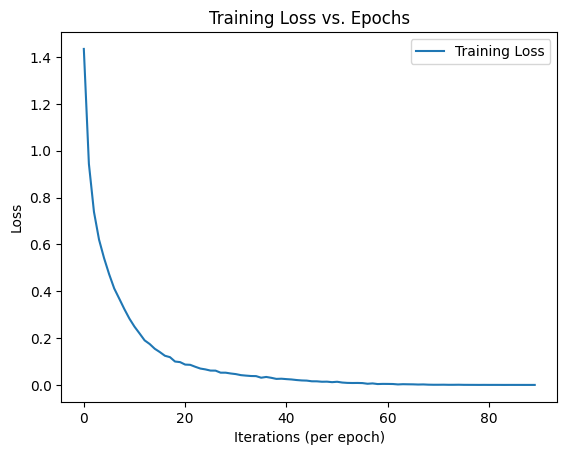

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)

# Constants
BATCH_SIZE = best_params['batch_size']  # Use the best batch size found
EPOCHS = 90  # Training for 90 epochs
NUM_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader for the full training set
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instantiate the model
model = ResNet20(num_classes=NUM_CLASSES).to(DEVICE)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Track loss for plotting
train_losses = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    scheduler.step()

    print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}')

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot the training loss curve
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iterations (per epoch)')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.show()


**Question 5**

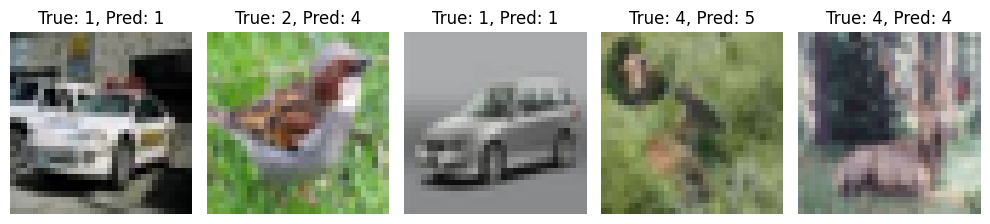

In [ ]:
import matplotlib.pyplot as plt
import random

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Combine true labels and predictions
incorrect_indices = np.where(predictions != true_labels)[0]
correct_indices = np.where(predictions == true_labels)[0]

num_samples = 5
sample_indices = random.sample(range(len(true_labels)), num_samples)

#including some correct and incorrect predictions
incorrect_samples = random.sample(list(incorrect_indices), 2)  # Include 2 incorrect
correct_samples = random.sample(list(correct_indices), num_samples - 2)  #Include 3 correct

# Combine selected samples
selected_indices = incorrect_samples + correct_samples
random.shuffle(selected_indices)

# Plot the samples
plt.figure(figsize=(10, 5))
for i, index in enumerate(selected_indices):
    plt.subplot(2, 5, i + 1)
    image = test_dataset[index][0]  # Get the image
    label = true_labels[index]  # True label
    pred = predictions[index]  # Predicted label

    # Convert tensor to numpy and denormalize
    image = image.permute(1, 2, 0)
    image = (image * 0.5) + 0.5

    plt.imshow(image.numpy())
    plt.title(f'True: {label}, Pred: {pred}')
    plt.axis('off')

plt.tight_layout()
plt.show()
